In [1]:
import collections
import gc
import itertools
import os
import sys
sys.path.append("/workspace/mta_vision_transformers/")
from collections import OrderedDict
from typing import Any, Callable, Dict, Iterable, List, Set, Tuple

import numpy as np
import einops
import torch
import torch.nn as nn
import torch.nn.functional as Fn
import torch.utils.data
from matplotlib import pyplot as plt
from tensordict import TensorDict
from torch.utils._pytree import tree_flatten

from core.monitor import Monitor
from infrastructure import utils
from infrastructure.settings import DEVICE, OUTPUT_DEVICE, DTYPE
from dataset.construct import ImageDataset
from dataset.library import DATASETS


dataset_name, n_classes = DATASETS["Common"][1]
OUTPUT_DIR = "experiments/plots"
EXPERIMENT_DIR = "figures"
if not os.path.exists(f"{OUTPUT_DIR}/{EXPERIMENT_DIR}"):
    os.makedirs(f"{OUTPUT_DIR}/{EXPERIMENT_DIR}", exist_ok=True)
    
# Ocean: 901085904
# Rose: 100390212
torch.set_printoptions(linewidth=400, sci_mode=False)

/opt/conda/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Seed: 1149496617


/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
from modeling.vit_attention import OpenCLIPAttentionViT
from visualize.base import construct_per_layer_output_dict


# SECTION: Set up model
torch.set_default_device(DEVICE)
model = OpenCLIPAttentionViT({}, stop_layer=None).to(DEVICE)


# SECTION: Set up monitor
def mean_attention_matrix_hook_fn(model_: nn.Module, input_: Any, output_: Any) -> Any:
    return torch.mean(einops.rearrange(
        tree_flatten(output_)[0][0],
        "b h n1 n2 -> b n1 n2 h"
    ), dim=-1)


monitor_config = OrderedDict({
    "model.visual.transformer.resblocks": OrderedDict({
        "": "layer_output",
        "attn.return_attn_matrix": [
            ("attention_matrix", mean_attention_matrix_hook_fn),
        ],
    })
})
monitor = Monitor(model, monitor_config, device=DEVICE)


# SECTION: Set up dataset
batch_size = 50
dataset = ImageDataset(dataset_name, split="train", return_original_image=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(DEVICE))
original_images, images = next(iter(dataloader))


# SECTION: Run baseline model
per_metric_output_dict = monitor.reset()
with torch.no_grad():
    output = model.forward(images)

per_layer_output_dict: List[TensorDict] = construct_per_layer_output_dict(per_metric_output_dict)

In [3]:
%matplotlib inline
from dataclasses import dataclass
from core.attention_sink import mask_attention_sink
from modeling.image_features import ImageFeatures


@dataclass
class ModelLog:
    start: int = None
    end: int = None
    model: OpenCLIPAttentionViT = None
    mask_config: Dict[int, Tuple[OpenCLIPAttentionViT.ModeOptions, OpenCLIPAttentionViT.MaskOptions]] = None
    attn_out_proj_bias: bool = None
    monitor: Monitor = None
    per_metric_output_dict: OrderedDict[str, np.ndarray[List[torch.Tensor]]] = None

save_experiment = False
mode = "mask"
mask_type = "X -> T"
mask_layer = 9
detection_layer = 13


attention_matrix_monitor_config = OrderedDict({
    "model.visual.transformer.resblocks.attn.return_attn_matrix": [
        ("attention_matrix", mean_attention_matrix_hook_fn),
    ],
})

model_dict: Dict[str, ModelLog] = {
    "train": ModelLog(start=mask_layer, end=detection_layer, mask_config={
        i: (mode, mask_type)
        for i in range(mask_layer, ImageFeatures.NUM_LAYERS)
    }, attn_out_proj_bias=True),
}

for k, log in model_dict.items():
    log.model = OpenCLIPAttentionViT(mask_config=log.mask_config, attn_out_proj_bias=log.attn_out_proj_bias, stop_layer=log.end + 1)
    log.monitor = Monitor(log.model, attention_matrix_monitor_config, device=DEVICE)


AS_mask: torch.Tensor = torch.full((batch_size, ImageFeatures.N + 1), False)
with torch.no_grad():
    attention_dict: Dict[str, Dict[int, List[torch.Tensor]]] = {k: {} for k in model_dict.keys()}
    
    it, max_it, start_vis_it = 1, 20, float("inf")
    convergence = False
    while not convergence and it <= max_it:
        for log in model_dict.values():
            log.per_metric_output_dict = log.monitor.reset()
            log.model.load_cache({"mask": AS_mask, "layer_output": [d["layer_output"] for d in per_layer_output_dict[:log.start]]})
            log.model.forward(images)

        for k, log in model_dict.items():
            for layer_idx in range(log.start, log.end + 1):
                attention_dict[k].setdefault(layer_idx, []).append(log.per_metric_output_dict["attention_matrix"][layer_idx][-1])

        # SECTION: Massive token heuristic
        new_MA_mask = mask_attention_sink(model_dict["train"].per_metric_output_dict["attention_matrix"][detection_layer].pop(), max_num_tokens=1, masked_tokens=AS_mask)
        
        # SECTION: Update the cumulative MA mask with the new attention sinks
        AS_mask = AS_mask + new_MA_mask
        it += 1
        
        # SECTION: Check convergence
        convergence = not torch.any(new_MA_mask).item()
        
        # SECTION: Cleanup
        for log in model_dict.values():
            log.per_metric_output_dict = None
            
        torch.cuda.empty_cache()
        gc.collect()

attentions: Dict[str, Dict[int, torch.Tensor]] = {k: {_k: torch.stack(_v, dim=1) for _k, _v in v.items()} for k, v in attention_dict.items()}
stacked_attention_matrix = attentions["train"][detection_layer]     # float: [bsz x ? x (N + 1) x (N + 1)]

In [4]:
import matplotlib.colors
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable

from visualize.base import CMAPScaleOptions, PLOT_SCALE, symmetrize


def get_min_max(t: torch.Tensor):
    return t[t > 0].min().item(), t.max().item()


def visualize_attention_matrix_per_iteration(
    layer_idx: int,
    iteration_indices: List[int],
    attention_weights: torch.Tensor,
    name_to_mask: Dict[str, torch.Tensor],
    transform_func: Callable[[torch.Tensor], torch.Tensor] = None,
    rescale_func: Callable[[torch.Tensor], torch.Tensor] = None,
    symmetric_cmap: bool = False,
    global_cmap: bool = True,
    cmap_scale: CMAPScaleOptions = "linear",
    subsample: float = 1.0,
    spacing: float = 0.1,
    spacing_color: str = "white",
    save_dir: str = None,
    **kwargs: Any,
) -> None:
    # Construct the rearranged attention weights
    bsz, N = attention_weights.shape[1:3]

    if attention_weights.ndim == 5:
        attention_weights = torch.mean(attention_weights, dim=-1)
    
    # Construct token masks for each cateogory
    flattened_mta_dict: OrderedDict[str, torch.Tensor] = OrderedDict({
        "CLS": (torch.arange(N) == 0).expand((bsz, -1)),
    })
    normal_mask = (torch.arange(N) > 0) * (torch.all(torch.isfinite(attention_weights).flatten(3, -1), dim=[0, -1]))
    for k, mask in name_to_mask.items():
        if k != "":
            flattened_mta_dict[k] = normal_mask * mask
        normal_mask = normal_mask * ~mask
    normal_mask = normal_mask * (torch.rand((bsz, N)) < subsample)
    flattened_mta_dict["Normal"] = normal_mask

    order_weights = torch.arange(N).repeat((bsz, 1))    
    for k, flattened_mta_mask in enumerate(flattened_mta_dict.values(), start=-len(flattened_mta_dict)):
        order_weights[flattened_mta_mask] += (2 * ImageFeatures.N) * k
    order = torch.argsort(order_weights, dim=1, stable=True)
    counts = torch.sum(order_weights < 0, dim=1)

    def get_attention_weights_for_image_idx(image_idx: int) -> torch.Tensor:
        _order = order[image_idx, :counts[image_idx]]
        return attention_weights[:, image_idx, _order[:, None], _order[None, :]]

    # Compute the widths of the rescaled attention image
    widths = torch.stack([
        torch.sum(flattened_mta_mask, dim=1)
        for flattened_mta_mask in flattened_mta_dict.values()
    ], dim=1)
    cumulative_widths = Fn.pad(torch.cumsum(widths, dim=1), (1, 0), mode="constant", value=0)
    
    if rescale_func is None:
        rescale_func = lambda t: t
    rescaled_widths = rescale_func(torch.mean(widths.to(torch.float32), dim=0).clamp_min_(1.0)) + 2 * spacing
    cumulative_rescaled_widths = (0.0, *torch.cumsum(rescaled_widths, dim=0).tolist())
    
    cutoff = cumulative_rescaled_widths[-1]
    aliases = (*flattened_mta_dict.keys(),)

    scale_dict: Dict[str, Callable[[float, float], str]] = {
        "linear": "Normalize",
        "log": "LogNorm",
        "arcsinh": "AsinhNorm",
    }
    norm = getattr(matplotlib.colors, scale_dict[cmap_scale])

    def plot_rescaled_attention(fig: Figure, ax: Axes, attention_weights: torch.Tensor, image_idx: int, global_vmin: float, global_vmax: float) -> None:
        if transform_func is not None:
            attention_weights = transform_func(attention_weights)
        
        sub_orders: List[torch.Tensor] = []
        for i in range(len(flattened_mta_dict)):
            sub_orders.append(torch.arange(widths[image_idx, i], device=DEVICE))
        
        vmin, vmax = (global_vmin, global_vmax) if global_cmap else get_min_max(attention_weights)
        attention_weights = attention_weights.clamp(vmin, vmax)
        
        if symmetric_cmap:
            vmin, vmax = symmetrize(vmin, vmax)

        ax.add_patch(Rectangle((0, 0), cumulative_rescaled_widths[-1], cumulative_rescaled_widths[-1], facecolor=spacing_color, zorder=-100)) 
        for i, j in itertools.product(
            range(len(flattened_mta_dict)),
            range(len(flattened_mta_dict))
        ):
            h0, h1 = cumulative_rescaled_widths[i] + spacing, cumulative_rescaled_widths[i + 1] - spacing
            w0, w1 = cumulative_rescaled_widths[j] + spacing, cumulative_rescaled_widths[j + 1] - spacing
            im = ax.imshow(
                attention_weights[
                    cumulative_widths[image_idx, i]:cumulative_widths[image_idx, i + 1],
                    cumulative_widths[image_idx, j]:cumulative_widths[image_idx, j + 1],
                ].numpy(force=True),
                extent=(w0, w1, h1, h0),
                norm=norm(vmin=vmin, vmax=vmax),
                interpolation="none", **kwargs
            )           
            if i == 0:
                ax.text(
                    (w0 + w1) / 2, -0.5, aliases[j],
                    ha="center", va="center", fontsize="large",
                )
            if j == 0:
                ax.text(
                    -0.5, (h0 + h1) / 2, aliases[i],
                    ha="center", va="center", fontsize="large", rotation="vertical",
                )
        
        fig.colorbar(im, cax=make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05), orientation="vertical")
        ax.set_xlim(left=0, right=cutoff)
        ax.set_ylim(top=0, bottom=cutoff)
        ax.axis("off")

    if transform_func is not None:
        suffix = f"_{transform_func.__name__}"
    else:
        suffix = ""
    
    for image_idx in [0]:
        image_attention_weights = get_attention_weights_for_image_idx(image_idx)
        global_vmin, global_vmax = get_min_max(image_attention_weights[iteration_indices])

        fig, axs = plt.subplots(nrows=1, ncols=len(iteration_indices), figsize=(PLOT_SCALE * len(iteration_indices), PLOT_SCALE))
        for ax_idx, it in enumerate(iteration_indices):
            ax: Axes = axs[ax_idx]
            
            if it == 0:
                title = "No Mask"
            elif it == 1:
                title = "Mask 1 Token"
            else:
                title = f"Mask {it} Tokens"
            
            ax.set_title(title, pad=24.0, fontsize="xx-large")
            plot_rescaled_attention(fig, ax, image_attention_weights[it], image_idx, global_vmin, global_vmax)
        fig.suptitle(f"Iterative Attention Masking at Layer {layer_idx}", fontsize=22, y=1.02)
        # plt.subplots_adjust(bottom=0.8)
        # fig.tight_layout()
        
        if save_dir is not None:
            from matplotlib.transforms import Bbox
            plt.savefig(
                f"{save_dir}/attention_iterations{iteration_indices}_image{image_idx}.pdf",
                bbox_inches="tight",
            )
            
            # bbox = fig.bbox
            # bbox = Bbox([[bbox.x0, bbox.y0 - 10], [bbox.x1, bbox.y1]])
            # plt.savefig(
            #     f"{save_dir}/attention_iterations{iteration_indices}_image{image_idx}.pdf",
            #     bbox_inches=bbox,   # bbox_inches="tight", pad_inches=[1],
            # )
        plt.show()
        plt.close()

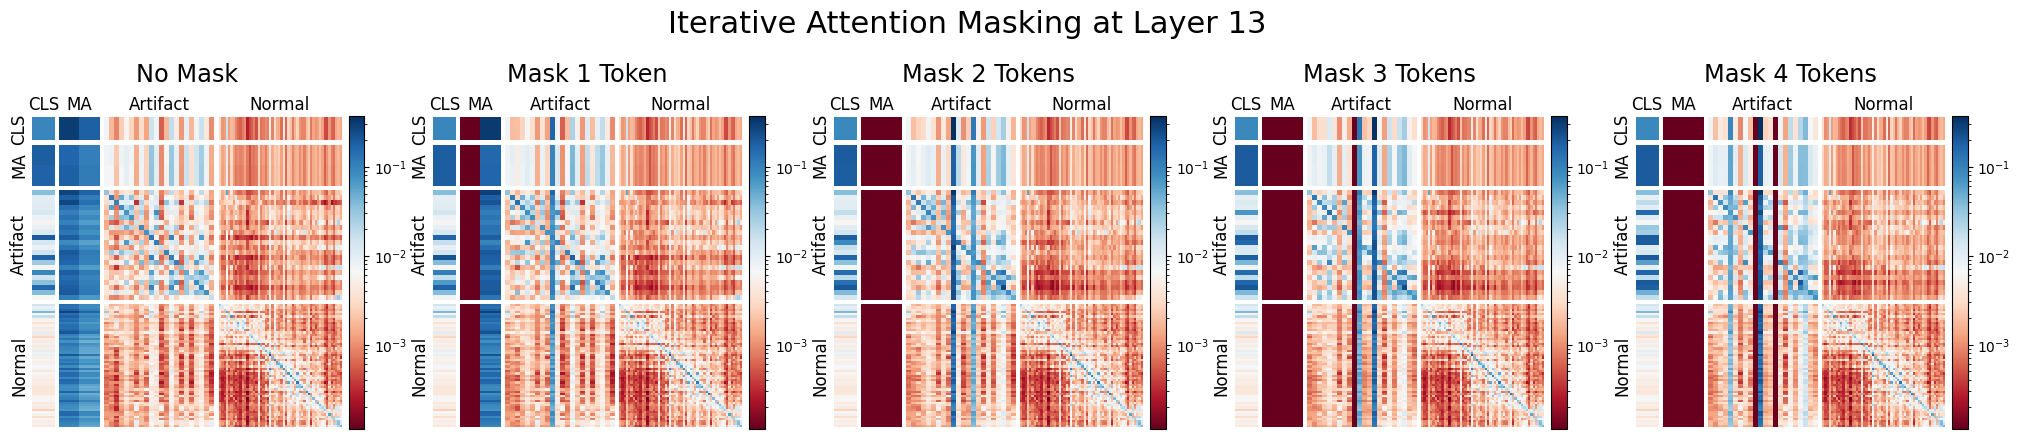

In [5]:
MA_mask: torch.Tensor = torch.load(f"experiments/saved_masks/MA_mask{batch_size}.pt", map_location=DEVICE)
AS_mask: torch.Tensor = torch.load(f"experiments/saved_masks/ranked_AS_mask{batch_size}.pt", map_location=DEVICE).isfinite()
mta_masks: Dict[int, torch.Tensor] = {
    "MA": MA_mask,
    "Artifact": AS_mask * ~MA_mask,
}

n_iter = 5
visualize_attention_matrix_per_iteration(
    detection_layer, [*range(n_iter)], stacked_attention_matrix.transpose(0, 1)[:n_iter], mta_masks,
    rescale_func=lambda t: torch.log2(t + 1), subsample=0.2, global_cmap=True, cmap="RdBu", cmap_scale="log", save_dir=f"{OUTPUT_DIR}/{EXPERIMENT_DIR}",
)